In [15]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns 
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


#### Obtention du jeu  de données nettoyé : 

In [16]:
file_path = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Projet_2/DATA_cleaned.csv"

DATA_prepared=pd.read_csv(file_path)


In [17]:
DATA_prepared

BuildingType PrimaryPropertyType            Neighborhood  \
0         NonResidential               Hotel                DOWNTOWN   
1         NonResidential               Hotel                DOWNTOWN   
2         NonResidential               Hotel                DOWNTOWN   
3         NonResidential               Hotel                DOWNTOWN   
4         NonResidential               Hotel                DOWNTOWN   
...                  ...                 ...                     ...   
1519  Nonresidential COS               Other  DELRIDGE NEIGHBORHOODS   
1520  Nonresidential COS               Other                DOWNTOWN   
1521  Nonresidential COS               Other   MAGNOLIA / QUEEN ANNE   
1522  Nonresidential COS  Mixed Use Property        GREATER DUWAMISH   
1523  Nonresidential COS  Mixed Use Property        GREATER DUWAMISH   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0     1920-1927                1.0              12             88434   
1     1992-1999                1.0              11            103566   
2     1968-1975                1.0              41            956110   
3     1920-1927                1.0              10             61320   
4     1976-1983                1.0              18            175580   
...         ...                ...             ...               ...   
1519  1976-1983                1.0               1             18261   
1520  2000-2007                1.0               1             16000   
1521  1968-1975                1.0               1             13157   
1522  1984-1991                1.0               1             14101   
1523  1936-1943                1.0               1             18258   

      PropertyGFAParking                          ListOfAllPropertyUseTypes  \
0                      0                                              Hotel   
1                  15064                         Hotel, Parking, Restaurant   
2                 196718                                              Hotel   
3                      0                                              Hotel   
4                  62000                      Hotel, Parking, Swimming Pool   
...                  ...                                                ...   
1519                   0                                 Other - Recreation   
1520                   0                                 Other - Recreation   
1521                   0  Fitness Center/Health Club/Gym, Other - Recrea...   
1522                   0  Fitness Center/Health Club/Gym, Food Service, ...   
1523                   0  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  ... SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  \
0                     Hotel  ...         182.500000         7.226362e+06   
1                     Hotel  ...         176.100006         8.387933e+06   
2                     Hotel  ...         241.899994         7.258702e+07   
3                     Hotel  ...         216.199997         6.794584e+06   
4                     Hotel  ...         211.399994         1.417261e+07   
...                     ...  ...                ...                  ...   
1519     Other - Recreation  ...         126.000000         9.320821e+05   
1520     Other - Recreation  ...         114.199997         9.502762e+05   
1521     Other - Recreation  ...         744.799988         5.765898e+06   
1522     Other - Recreation  ...         105.300003         7.194712e+05   
1523     Other - Recreation  ...         115.800003         1.152896e+06   

      SteamUse(kBtu) Electricity(kWh) Electricity(kBtu)  NaturalGas(therms)  \
0                Oui              Oui               Oui                 Oui   
1                Non              Oui               Oui                 Oui   
2                Oui              Oui               Oui                 Oui   
3                Oui              Oui               Oui                 Oui   
4                Non     

In [18]:
DATA_prepared = DATA_prepared[DATA_prepared["TotalGHGEmissions"] > 0]

TotalGHGEmission = DATA_prepared["TotalGHGEmissions"]
DATA_prepared.drop(["SiteEnergyUse(kBtu)","TotalGHGEmissions"], axis=1, inplace=True)

C:\Users\pdevi\AppData\Local\Temp\ipykernel_15576\3179293023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA_prepared.drop(["SiteEnergyUse(kBtu)","TotalGHGEmissions"], axis=1, inplace=True)


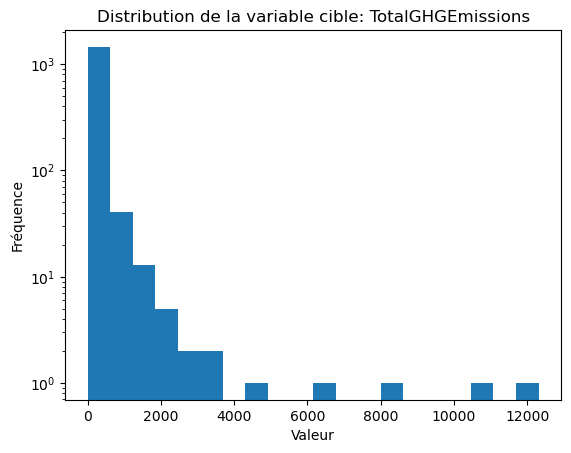

In [19]:
plt.hist(TotalGHGEmission,bins=20)
plt.title("Distribution de la variable cible: TotalGHGEmissions")
plt.xlabel("Valeur")
plt.ylabel("Fréquence")
plt.yscale("log")

## Normalisation des valeurs 

In [20]:
# Préparation des données pour l'apprentissage
X_emission = DATA_prepared

y_emission = np.log(TotalGHGEmission)

# Séparation des données en ensembles d'entraînement et de test
X_train_emission, X_test_emission, y_train_emission, y_test_emission = train_test_split(X_emission, y_emission, test_size=0.2, random_state=42)

# Prétraitement : encodage des variables catégorielles et normalisation des variables numériques
colonnes_numeriques = X_emission.select_dtypes(include=['int64', 'float64']).columns
colonnes_categoriques = X_emission.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonnes_numeriques),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='if_binary'), colonnes_categoriques)
    ]
)

pipeline_pretraitement = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_prepared_emission = pipeline_pretraitement.fit_transform(X_train_emission)
X_test_prepared_emission = pipeline_pretraitement.transform(X_test_emission)

C:\Users\pdevi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [4, 5, 6, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Mise en œuvre du premier algorithme d'IA pour la prédiction : Regression linéaire

Pour le premier algorithme d'IA, nous utiliserons la régression linéaire car il s'agit d'un algorithme fondamental pour les problèmes de régression. Nous l'entraînerons pour prédire TotalGHGEmissions à partir de nos features sélectionnées.

Ces segments de code entraînent un modèle de régression linéaire pour notre variables cible et évalue ses performances à l'aide des métriques Mean Square Error (MSE), MAPE et R². Il trace également les valeurs réelles et prédites pour évaluer visuellement la précision du modèle.

In [21]:
target="TotalGHGEmissions"

Performance du modèle pour TotalGHGEmissions:
MSE: 5245751.31, RMSE: 2290.36, R2: -20.06, MAPE: 120.63%
Temps d'entraînement: 0.0314 secondes
Temps total d'exécution: 0.0314 secondes


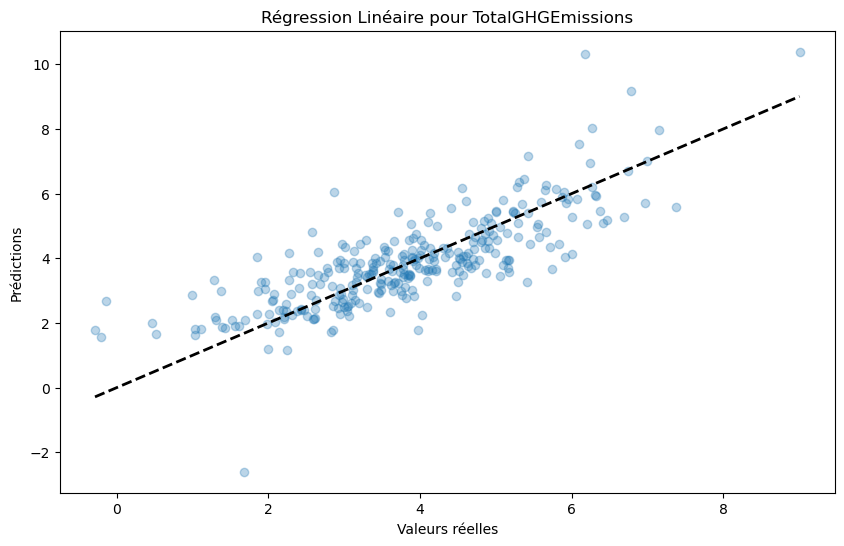

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

# Initialisation du modèle de régression linéaire
modele_lr = LinearRegression()

# Début du chronomètre pour le temps d'exécution
start_time = time.time()

# Entraînement du modèle sur les données d'entraînement
modele_lr.fit(X_train_prepared_emission, y_train_emission)

# Calcul du temps d'entraînement
training_time = time.time() - start_time

# Prédiction sur les données de test
y_pred = modele_lr.predict(X_test_prepared_emission)

# Calcul du temps total d'exécution (entraînement + prédiction)
total_time = time.time() - start_time

# Calcul des métriques de performance
mse = mean_squared_error(np.exp(y_test_emission), np.exp(y_pred))
rmse = np.sqrt(mse)  # RMSE est la racine carrée de MSE
r2 = r2_score(np.exp(y_test_emission), np.exp(y_pred))

# Calcul de MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(np.exp(y_test_emission), np.exp(y_pred))

print(f"Performance du modèle pour {target}:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAPE: {mape:.2f}%")
print(f"Temps d'entraînement: {training_time:.4f} secondes")
print(f"Temps total d'exécution: {total_time:.4f} secondes")

# Tracé de la régression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_emission, y_pred, alpha=0.3)
plt.plot([y_test_emission.min(), y_test_emission.max()], [y_test_emission.min(), y_test_emission.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Régression Linéaire pour {target}')
plt.show()


# Implémentation du deuxième algorithme d'IA : arbre de décision

Pour notre deuxième modèle d'IA, nous utiliserons un régresseur d'arbre de décision. Les arbres de décision offrent un modèle plus complexe capable de capturer les relations non linéaires entre les fonctionnalités et les cibles. Ce modèle sera entraîné pour prédire TotalGHGEmissions.

Performance du modèle pour TotalGHGEmissions:
MSE: 85267.98, RMSE: 292.01, R2: 0.66, MAPE: 89.62%
Temps d'entraînement: 0.0684 secondes
Temps total d'exécution: 0.0684 secondes


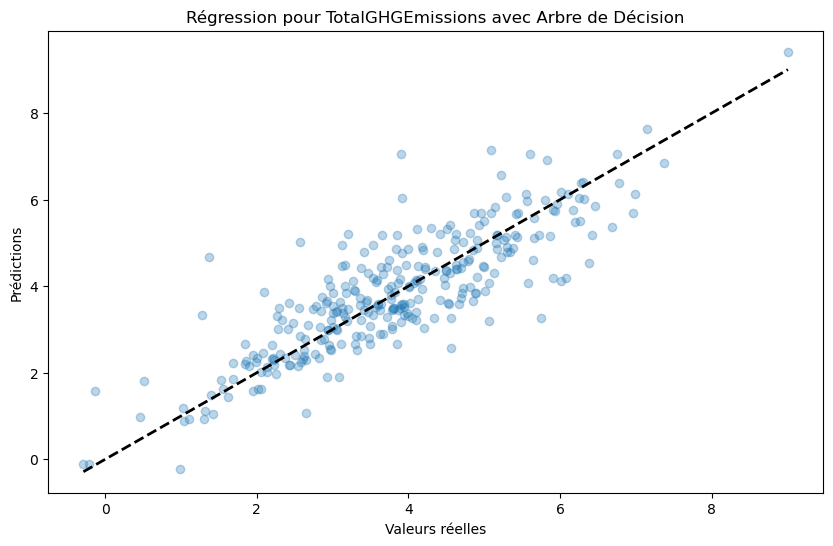

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

target="TotalGHGEmissions"

# Initialisation du modèle de l'arbre de décision
modele_ad = DecisionTreeRegressor(random_state=42)

# Début du chronomètre pour le temps d'exécution
start_time = time.time()

# Entraînement du modèle sur les données d'entraînement
modele_ad.fit(X_train_prepared_emission, y_train_emission)

# Calcul du temps d'entraînement
training_time = time.time() - start_time

# Prédiction sur les données de test avec le modèle correct
y_pred = modele_ad.predict(X_test_prepared_emission)

# Calcul du temps total d'exécution (entraînement + prédiction)
total_time = time.time() - start_time

# Calcul des métriques de performance
mse = mean_squared_error(np.exp(y_test_emission), np.exp(y_pred))
rmse = np.sqrt(mse)  # RMSE est la racine carrée de MSE
r2 = r2_score(np.exp(y_test_emission), np.exp(y_pred))

# Calcul de MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(np.exp(y_test_emission),np.exp( y_pred))

print(f"Performance du modèle pour {target}:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAPE: {mape:.2f}%")
print(f"Temps d'entraînement: {training_time:.4f} secondes")
print(f"Temps total d'exécution: {total_time:.4f} secondes")

# Tracé de la régression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_emission, y_pred, alpha=0.3)
plt.plot([y_test_emission.min(), y_test_emission.max()], [y_test_emission.min(), y_test_emission.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Régression pour {target} avec Arbre de Décision')
plt.show()


### Explorer l'importance des variables et affiner le modèle d'arbre de décision


Pour affiner notre modèle d'arbre de décision et comprendre l'impact des différentes fonctionnalités sur nos prédictions, nous pouvons examiner l'importance des fonctionnalités fournies par le modèle. Ces informations aident à comprendre quelles caractéristiques contribuent le plus à prédire la consommation d’énergie et les émissions de gaz à effet de serre. Sur la base de ces informations, nous pourrions ajuster notre modèle, éventuellement en le simplifiant en supprimant les fonctionnalités les moins importantes ou en nous concentrant sur les plus importantes pour une analyse plus approfondie.

Commençons par extraire et visualiser l'importance des fonctionnalités pour l'une de nos variables cibles avec le modèle d'arbre de décision :

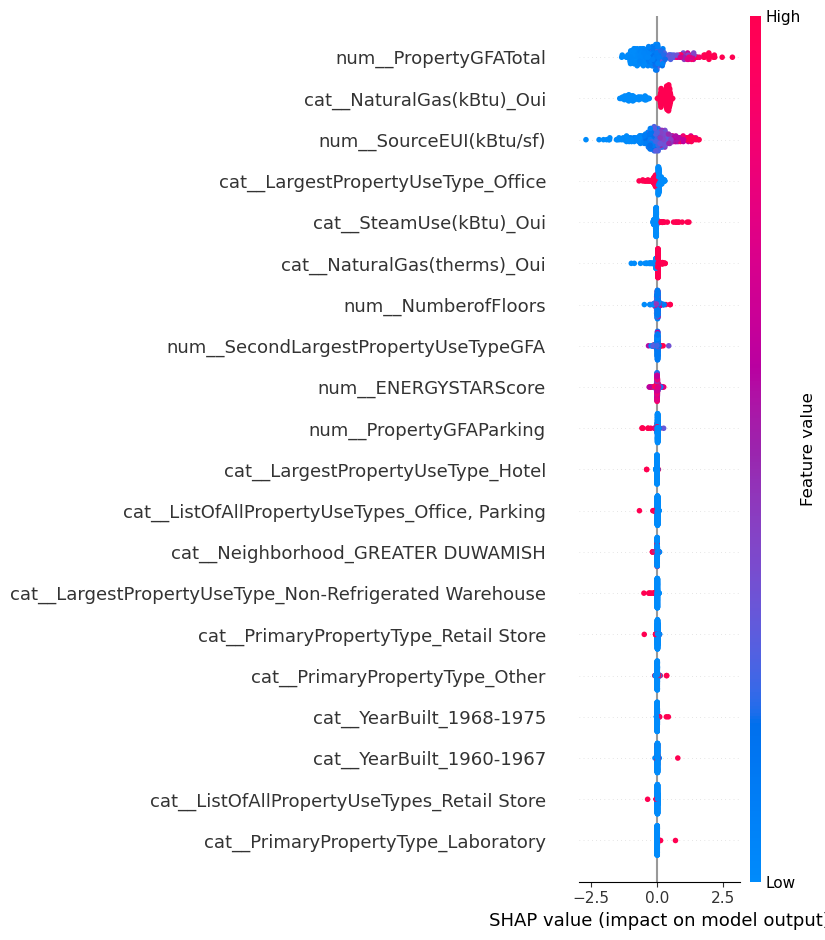

In [24]:
# Convert the training and test data from sparse to dense format
X_train_prepared_emission = X_train_prepared_emission.toarray()
X_test_prepared_emission = X_test_prepared_emission.toarray()

# Initialize the SHAP Explainer with the dense format data
explainer = shap.Explainer(modele_ad, X_train_prepared_emission)

# Calculate SHAP values for the dense format test data
shap_values = explainer(X_test_prepared_emission,check_additivity=False)

# Summary plot with feature names obtained from the preprocessor
feature_names = pipeline_pretraitement.get_feature_names_out()

shap.summary_plot(shap_values, feature_names=feature_names)


In [25]:
# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
# Create a list of feature names and their corresponding mean absolute SHAP values
feature_importance = list(zip(feature_names, mean_shap_values))

# Sort the features by their importance scores in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
# Print the top 10 features and their importance scores
# Get the top 10 features and their SHAP values
top_10_features = sorted_features[:10]

for feature, importance in top_10_features:
    print(f"Feature: {feature}, SHAP Value: {importance:.4f}")


Feature: num__PropertyGFATotal, SHAP Value: 0.5915
Feature: cat__NaturalGas(kBtu)_Oui, SHAP Value: 0.5050
Feature: num__SourceEUI(kBtu/sf), SHAP Value: 0.4913
Feature: cat__LargestPropertyUseType_Office, SHAP Value: 0.0988
Feature: cat__SteamUse(kBtu)_Oui, SHAP Value: 0.0933
Feature: cat__NaturalGas(therms)_Oui, SHAP Value: 0.0646
Feature: num__NumberofFloors, SHAP Value: 0.0407
Feature: num__SecondLargestPropertyUseTypeGFA, SHAP Value: 0.0316
Feature: num__ENERGYSTARScore, SHAP Value: 0.0297
Feature: num__PropertyGFAParking, SHAP Value: 0.0268


Après avoir compris quelles caractéristiques sont les plus influentes dans nos prédictions, nous pourrions envisager plusieurs améliorations du modèle d'arbre de décision :

**Élagage de l'arbre** : limitez la profondeur de l'arbre ou définissez un nombre minimum d'échantillons requis au niveau d'un nœud feuille pour éviter le surajustement et potentiellement améliorer la généralisation du modèle.

**Réglage des hyperparamètres** : expérimentez différents hyperparamètres du modèle d'arbre de décision pour trouver la configuration optimale pour notre ensemble de données spécifique.

In [26]:
# Réglage de la profondeur maximale de l'arbre pour éviter le surajustement
modele_ad_refined = DecisionTreeRegressor(max_depth=5, random_state=42)

modele_ad_refined.fit(X_train_prepared_emission, y_train_emission)
y_pred_emission = modele_ad_refined.predict(X_test_prepared_emission)

mse_refined = mean_squared_error(np.exp(y_test_emission), np.exp(y_pred_emission))
rmse_refined = np.sqrt(mse_refined)
r2_refined = r2_score(np.exp(y_test_emission), np.exp(y_pred_emission))
mape_refined = mean_absolute_percentage_error(np.exp(y_test_emission), np.exp(y_pred_emission))
print(f"MSE raffiné: {mse_refined:.2f}, RMSE raffiné: {rmse_refined:.2f}, R2 raffiné: {r2_refined:.2f}, MAPE raffiné: {mape_refined:.2f}%")

MSE raffiné: 47723.41, RMSE raffiné: 218.46, R2 raffiné: 0.81, MAPE raffiné: 77.61%


# Implémentation du troisième algorithme d'IA : Random Forest


Pour le troisième modèle d'IA, nous utiliserons un régresseur de forêt aléatoire. Random Forest est une méthode d'ensemble qui utilise plusieurs arbres de décision pour améliorer la précision des prédictions et contrôler le surajustement. Il est particulièrement adapté à la gestion d'ensembles de données complexes avec des relations non linéaires entre les entités et les variables cibles.

Implémentons un modèle de forêt aléatoire pour prédire TotalGHGEmissions.

Performance du modèle pour TotalGHGEmissions:
MSE: 45610.31, RMSE: 213.57, R2: 0.82, MAPE: 84.47%
Temps d'entraînement: 0.0397 secondes
Temps total d'exécution: 0.0397 secondes


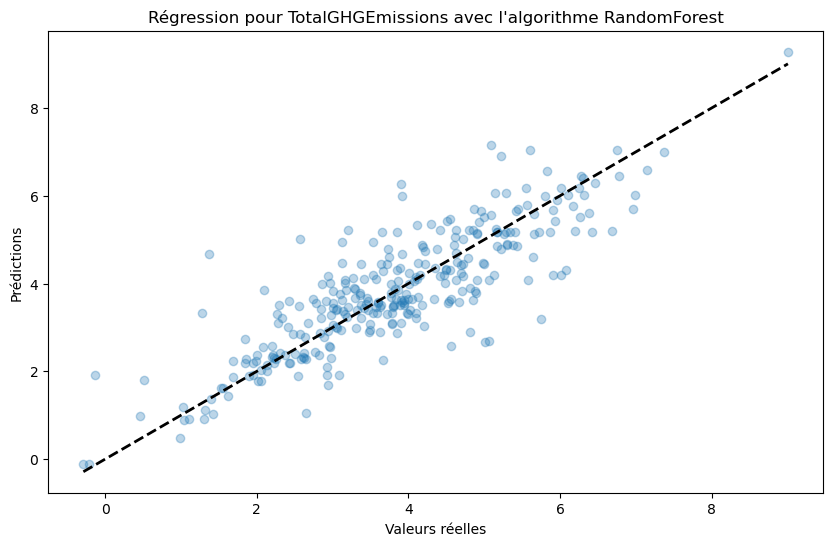

In [27]:
target="TotalGHGEmissions"


# Initialisation du modèle Random Forest
modele_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Début du chronomètre pour le temps d'exécution
start_time = time.time()

# Entraînement du modèle sur les données d'entraînement
modele_ad.fit(X_train_prepared_emission, y_train_emission)

# Calcul du temps d'entraînement
training_time = time.time() - start_time

# Prédiction sur les données de test avec le modèle correct
y_pred = modele_ad.predict(X_test_prepared_emission)

# Calcul du temps total d'exécution (entraînement + prédiction)
total_time = time.time() - start_time

# Calcul des métriques de performance
mse = mean_squared_error(np.exp(y_test_emission), np.exp(y_pred))
rmse = np.sqrt(mse)  # RMSE est la racine carrée de MSE
r2 = r2_score(np.exp(y_test_emission), np.exp(y_pred))

# Calcul de MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(np.exp(y_test_emission),np.exp( y_pred))

print(f"Performance du modèle pour {target}:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAPE: {mape:.2f}%")
print(f"Temps d'entraînement: {training_time:.4f} secondes")
print(f"Temps total d'exécution: {total_time:.4f} secondes")

# Tracé de la régression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_emission, y_pred, alpha=0.3)
plt.plot([y_test_emission.min(), y_test_emission.max()], [y_test_emission.min(), y_test_emission.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f"Régression pour {target} avec l'algorithme RandomForest")
plt.show()

### Réglage des hyperparamètres pour le modèle de forêt aléatoire

Le réglage des hyperparamètres est une étape critique pour optimiser les performances d'un modèle Random Forest. Nous utiliserons une recherche de grille à validation croisée pour trouver la meilleure combinaison de paramètres pour notre modèle. Ce processus implique une recherche dans un sous-ensemble spécifié d'hyperparamètres pour déterminer les valeurs optimales qui aboutissent aux meilleures performances du modèle.

Effectuons un réglage des hyperparamètres sur le régresseur de forêt aléatoire pour améliorer la précision de la prédiction de notre variable cible.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Meilleurs paramètres trouvés :  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
MSE raffiné: 83349.66, RMSE raffiné: 288.70, R2 raffiné: 0.67, MAPE raffiné: 53.15%


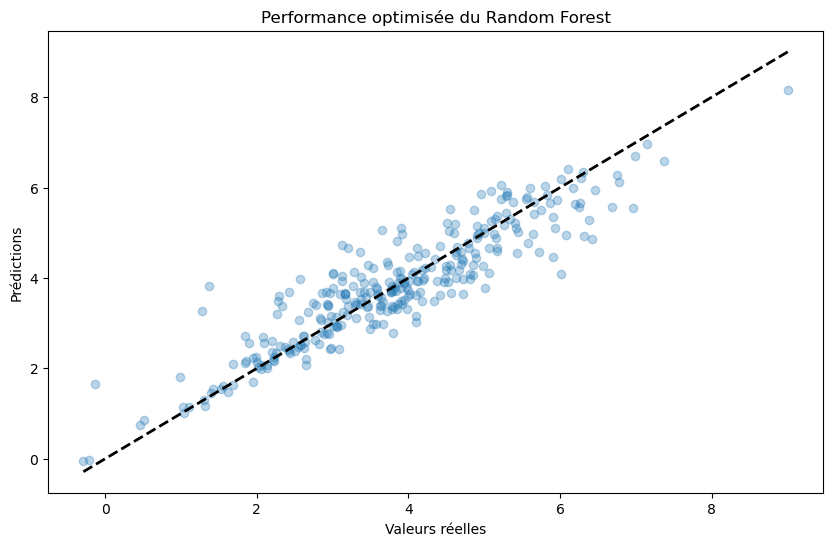

In [28]:
from sklearn.model_selection import GridSearchCV

# Definition des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres dans la forêt
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimal de données requises pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimal de données requises à un nœud terminal (feuille)
}

# Initialisation du modèle Random Forest avec GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Nombre de folds pour la validation croisée
                           n_jobs=-1,  # Utilisation de tous les processeurs disponibles
                           verbose=2)

# Entraînement du GridSearchCV
grid_search.fit(X_train_prepared_emission, y_train_emission)

# Meilleurs paramètres
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

# Evaluation du modèle avec les meilleurs paramètres sur l'ensemble de test
best_model = grid_search.best_estimator_
y_pred_emission = best_model.predict(X_test_prepared_emission)

mse_refined = mean_squared_error(np.exp(y_test_emission),np.exp( y_pred_emission))
rmse_refined=np.sqrt(mse_refined)
r2_refined = r2_score(np.exp(y_test_emission), np.exp(y_pred_emission))
mape_refined = mean_absolute_percentage_error(np.exp(y_test_emission),np.exp(y_pred_emission))
print(f"MSE raffiné: {mse_refined:.2f}, RMSE raffiné: {rmse_refined:.2f}, R2 raffiné: {r2_refined:.2f}, MAPE raffiné: {mape_refined:.2f}%")
# Visualisation de la performance du modèle optimisé
plt.figure(figsize=(10, 6))
plt.scatter(y_test_emission, y_pred_emission, alpha=0.3)
plt.plot([y_test_emission.min(), y_test_emission.max()], [y_test_emission.min(), y_test_emission.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Performance optimisée du Random Forest')
plt.show()

Ce segment met en place une recherche de grille pour optimiser les hyperparamètres du modèle Random Forest, en se concentrant sur n_estimators, max_degree, min_samples_split et min_samples_leaf. Il évalue les performances du modèle optimisé à l'aide des métriques MSE et R² et visualise les prédictions par rapport aux valeurs réelles.